# **Membuat Model Machine Learning dengan Data Time Series**
## London Temperature Machine Learning using Timeseries

## Profile

**Achmad Hadi Kurnia**

Link [Dicoding](https://www.dicoding.com/users/achmadhadikurnia)

## Kriteria
- [x] Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.
- [x] Harus menggunakan LSTM dalam arsitektur model.
- [x] Validation set sebesar 20% dari total dataset.
- [x] Model harus menggunakan model sequential.
- [x] Harus menggunakan Learning Rate pada Optimizer.
- [x] MAE < 10% skala data.

## Saran untuk Penilaian Lebih Tinggi
- [x] Dataset yang digunakan memiliki banyak sampel data.
- [x] Mengimplementasikan Callback.
- [x] Membuat plot loss dan akurasi pada saat training dan validation.

### 1. Setup Kebutuhan

In [11]:
# Unduh dataset
!wget https://raw.githubusercontent.com/achmadhadikurnia/london-temp-ml-timeseries-dicoding-submission/main/datasets/data.csv

# Impor libary
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split

--2023-12-21 15:53:07--  https://raw.githubusercontent.com/achmadhadikurnia/london-temp-ml-timeseries-dicoding-submission/main/datasets/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1120287 (1.1M) [text/plain]
Saving to: ‘data.csv.2’

data.csv.2          100%[===================>]   1.07M  --.-KB/s    in 0.006s  

2023-12-21 15:53:08 (184 MB/s) - ‘data.csv.2’ saved [1120287/1120287]



### 2. Menyiapkan data

<class 'pandas.core.frame.DataFrame'>
Index: 52416 entries, 1/1/2017 0:00 to 12/30/2017 23:50
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    52416 non-null  float64
dtypes: float64(1)
memory usage: 819.0+ KB
None


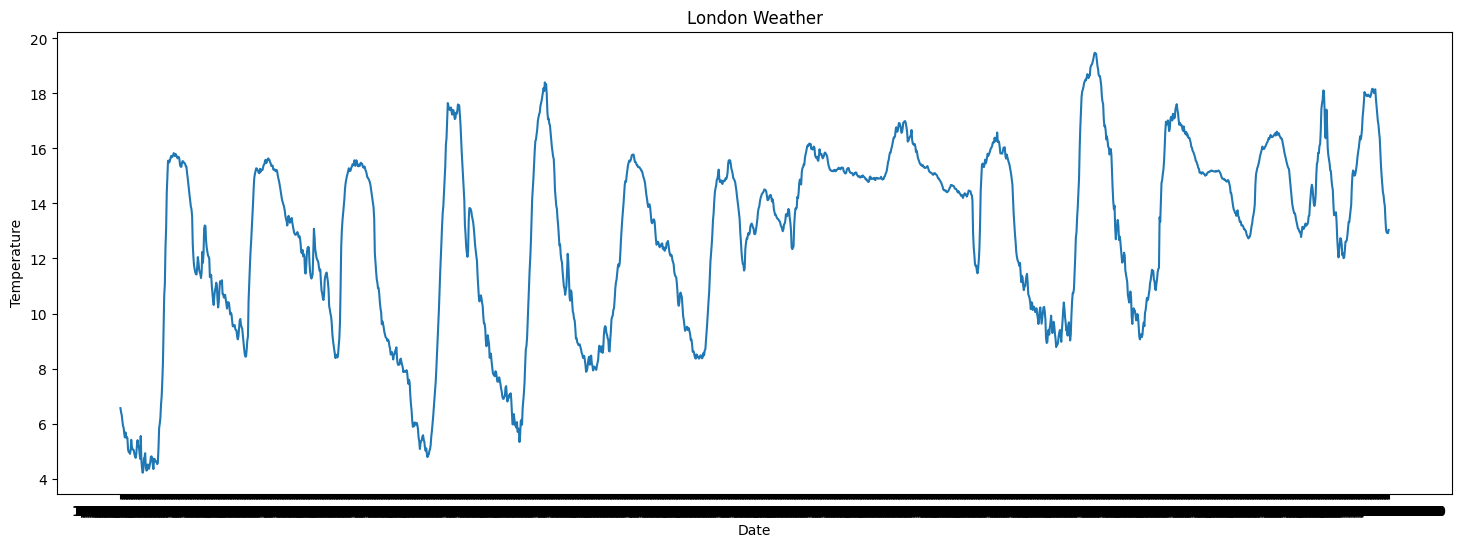

In [16]:
# Membaca data
data = pd.read_csv('/content/data.csv', delimiter=',')
date = data['date'].values
temp = data['temp'].values
data.set_index('date', inplace= True)

# Menampilkan info data
print(data.info())

# Menampilkan plot data
plt.figure(figsize=(18, 6))
plt.plot(date[:2000], temp[:2000])
plt.title('London Weather')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

### 3. Modeling

In [18]:
# Membuat windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

# Split data menjadi train dan test
train_x, val_x, train_y, val_y = train_test_split(date, temp, test_size=0.2, shuffle=False)
train_set = windowed_dataset(train_y, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(val_y, window_size=60, batch_size=100, shuffle_buffer=1000)
print('train_set: ', len(train_x))
print('train_set: ', len(val_x))

# Sequential
model = tf.keras.Sequential([
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-05, momentum=0.9)
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = optimizer,
  metrics = ['mae'],
)

# Hitung MAE
mae = (data['temp'].max() - data['temp'].min()) * 0.1
print('MAE: ', mae)

# Callback
class maeCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<mae and logs.get('val_mae')<mae):
      print("\nNilai MAE sudah <10% dari skala data")
      self.model.stop_training = True
callbacks = maeCallback()

# Pelatihan
history = model.fit(
  train_set,
  epochs = 32,
  validation_data = val_set,
  callbacks = [callbacks],
  verbose=2
)

train_set:  41932
train_set:  10484
MAE:  3.6763
Epoch 1/32
419/419 - 14s - loss: 17.8475 - mae: 18.3475 - val_loss: 13.3286 - val_mae: 13.8286 - 14s/epoch - 33ms/step
Epoch 2/32
419/419 - 11s - loss: 15.8122 - mae: 16.3122 - val_loss: 10.6878 - val_mae: 11.1878 - 11s/epoch - 26ms/step
Epoch 3/32
419/419 - 9s - loss: 11.4722 - mae: 11.9722 - val_loss: 4.3554 - val_mae: 4.8378 - 9s/epoch - 22ms/step
Epoch 4/32
419/419 - 8s - loss: 2.7874 - mae: 3.2540 - val_loss: 4.5326 - val_mae: 5.0271 - 8s/epoch - 19ms/step
Epoch 5/32
419/419 - 9s - loss: 2.5480 - mae: 3.0105 - val_loss: 4.0767 - val_mae: 4.5709 - 9s/epoch - 22ms/step
Epoch 6/32

Nilai MAE sudah <10% dari skala data
419/419 - 11s - loss: 1.9625 - mae: 2.4076 - val_loss: 2.9504 - val_mae: 3.4172 - 11s/epoch - 26ms/step


## 4. Plot

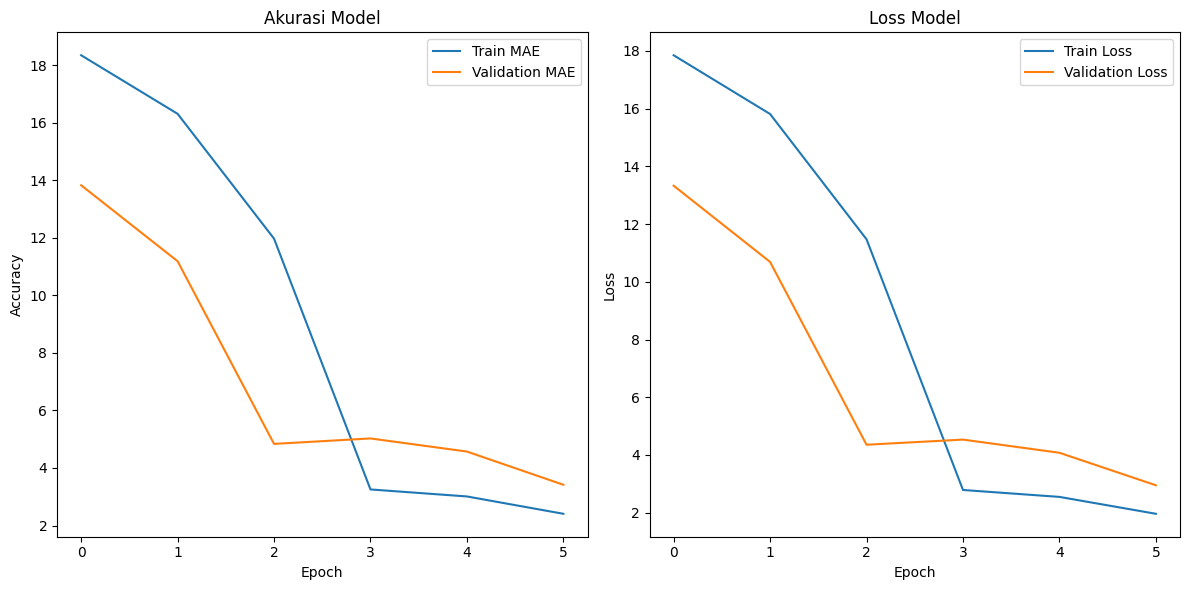

In [20]:
# Data akurasi
train_accuracy = history.history['mae']
val_accuracy = history.history['val_mae']

# Data loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy
axes[0].plot(train_accuracy, label='Train MAE')
axes[0].plot(val_accuracy, label='Validation MAE')
axes[0].set_title('Akurasi Model')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='upper right')

# Plot loss
axes[1].plot(train_loss, label='Train Loss')
axes[1].plot(val_loss, label='Validation Loss')
axes[1].set_title('Loss Model')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()